In [16]:

import datetime as dt
import warnings

import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import find_peaks
from sklearn.ensemble import IsolationForest

#--- Need Plotly for plotting-------------
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt


import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
oilprice= pd.read_csv('./oil.csv')
holiday = pd.read_csv('./holidays_events.csv')
train = pd.read_csv('./train.csv')
transactions = pd.read_csv('./transactions.csv')
stores= pd.read_csv('./stores.csv')

# preprocessing
*Oil Price*

In [18]:
oilprice_df = oilprice.fillna(method='bfill')

*Holiday*

In [19]:
holiday['isHoliday']=1
holiday.rename(columns={'type' : 'holidayType'}, inplace=True)
holiday_df = holiday[['date','isHoliday','holidayType']]

*train*

In [20]:
train.drop('id', axis=1,inplace=True)
df = pd.merge(train, holiday_df, on='date', how='left')
df.loc[df['isHoliday'].isna(), 'holidayType'] = 'Not_holiday'

df.loc[df['isHoliday'].isna(), 'isHoliday'] = 0


In [21]:
df = pd.merge(df, oilprice, on='date', how='left')
df['dcoilwtico'].fillna(method='bfill', inplace=True)
df = df[((df['date']>'2016-05-16')|( '2016-04-16'> df['date']))]

#### let's explore data a bit :)

In [22]:

temp  = df.groupby('date')[['sales','dcoilwtico','isHoliday']].agg({'sales':'sum', 'dcoilwtico':'mean' , 'isHoliday':'max'})

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=temp.index, y=temp.sales, name="sales", mode="markers"),
    secondary_y=False
)
fig.add_trace(
    go.Scatter(x=temp.index, y=temp.dcoilwtico, name="WTI oil price", mode="lines"),
    secondary_y=True, 
)
fig.add_trace(
    go.Scatter(x=temp[temp['isHoliday']==1].index, 
               y=temp['isHoliday'][temp['isHoliday']==1] * temp['sales'][temp['isHoliday']==1], name="Holiday", mode="markers"),
    secondary_y=False, 
)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Sales", secondary_y=False)
fig.update_yaxes(title_text="WTI oil price", secondary_y=True)

##### earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake. It seems some outliers exist in our data lets remove this by the help of the Isolation forest. 

In [24]:
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(temp['sales'].values.reshape(-1,1))

IsolationForest(contamination=0.1, n_estimators=50)

In [25]:
temp['anomaly'] = model.decision_function(temp['sales'].values.reshape(-1,1))
temp['anomaly'] = np.where( temp['anomaly'] <0, 'outlier' , 'normal')


In [26]:
px.histogram(temp , x='sales',color='anomaly', marginal='box')

In [27]:
possible_outlier_days= temp[temp['anomaly']=='outlier'].index
df = df[~df['date'].isin(possible_outlier_days)]
# df = df[df['sales'] < 5e6]

In [28]:
stores.rename(columns={'type' : 'storeType'}, inplace = True)
stores_df= stores[['store_nbr' ,'storeType','city','cluster']]

In [29]:
df = pd.merge(df, stores_df, on='store_nbr', how='left')

#since we do not have transactions on the test set, so it is better to remove the transactions from the train set:(
# df = pd.merge(df, transactions, on=['store_nbr','date'], how='left')


In [30]:
# x=df.groupby('date')['sales','dcoilwtico'].agg('mean')
# x['sales_to_oil_ratio']= (x['sales']/x['dcoilwtico'])

In [31]:
# df = pd.merge(df, x[['sales_to_oil_ratio']], on='date', how='left')

we can see in the sum 

In [32]:
px.imshow(df.corr())

In [33]:
df.isna().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
isHoliday      0
holidayType    0
dcoilwtico     0
storeType      0
city           0
cluster        0
dtype: int64

In [34]:
from sklearn.preprocessing import OrdinalEncoder

encoder_holidays = OrdinalEncoder()
encoder_holidays.fit(df['holidayType'].values.reshape(-1,1))
df['holidayType'] = encoder_holidays.transform(df['holidayType'].values.reshape(-1,1))



In [35]:
encoder_family = OrdinalEncoder()
encoder_family.fit(df['family'].values.reshape(-1,1))
df['family'] = encoder_family.transform(df['family'].values.reshape(-1,1))

In [36]:

encoder_storeType = OrdinalEncoder()
encoder_storeType.fit(df['storeType'].values.reshape(-1,1))
df['storeType'] = encoder_storeType.transform(df['storeType'].values.reshape(-1,1))


In [37]:

encoder_city = OrdinalEncoder()
encoder_city.fit(df['city'].values.reshape(-1,1))
df['city'] = encoder_city.transform(df['city'].values.reshape(-1,1))

In [38]:
df

,date,store_nbr,family,sales,onpromotion,isHoliday,holidayType,dcoilwtico,storeType,city,cluster
0,2013-01-02,1,0.0,2.000,0,0.0,4.0,93.14,3.0,18.0,13
1,2013-01-02,1,1.0,0.000,0,0.0,4.0,93.14,3.0,18.0,13
2,2013-01-02,1,2.0,2.000,0,0.0,4.0,93.14,3.0,18.0,13
3,2013-01-02,1,3.0,1091.000,0,0.0,4.0,93.14,3.0,18.0,13
4,2013-01-02,1,4.0,0.000,0,0.0,4.0,93.14,3.0,18.0,13
...,...,...,...,...,...,...,...,...,...,...,...
2656957,2017-08-15,9,28.0,438.133,0,1.0,3.0,47.57,1.0,18.0,6
2656958,2017-08-15,9,29.0,154.553,1,1.0,3.0,47.57,1.0,18.0,6
2656959,2017-08-15,9,30.0,2419.729,148,1.0,3.0,47.57,1.0,18.0,6
2656960,2017-08-15,9,31.0,121.000,8,1.0,3.0,47.57,1.0,18.0,6


In [59]:
df_clean = df[~df['date'].isin(possible_outlier_days)].copy()

In [60]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from sklearn.decomposition import PCA



df_clean['date'] = pd.to_datetime(df_clean['date'])
df_clean['dayoftheWeek'] = df_clean['date'].apply(lambda x: x.isoweekday())
df_clean['month'] = df_clean['date'].apply(lambda x: x.month)

y = df_clean['sales'] 
df_clean.drop(['sales','date'], axis=1, inplace=True)
pca = PCA(n_components=8)

X= pca.fit_transform(df_clean)


In [61]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [62]:
from sklearn.ensemble import RandomForestRegressor
RandomForest = RandomForestRegressor(n_estimators = 10)
RandomForest.fit(X_train,y_train)
RandomForest.score(X_test,y_test)

0.9426890474496207

In [79]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=200, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [80]:
model.score(X_test,y_test)

0.90027321007626

## Let's take the model predict the test set

In [84]:
test = pd.read_csv('./test.csv')

In [85]:
ids= test['id'].astype(str).copy()
test.drop('id',axis=1,inplace=True)


In [86]:
df_test = pd.merge(test, holiday_df, on='date', how='left')
df_test.loc[df_test['isHoliday'].isna(), 'holidayType'] = 'Not_holiday'
df_test.loc[df_test['isHoliday'].isna(), 'isHoliday'] = 0

In [87]:
df_test = pd.merge(df_test, oilprice, on='date', how='left')
df_test['dcoilwtico'].fillna(method='bfill', inplace=True)

In [88]:
df_test = pd.merge(df_test, stores_df, on='store_nbr', how='left')
# df_test = pd.merge(df_test, transactions, on=['store_nbr','date'], how='left')

In [89]:
df_test['holidayType'] = encoder_holidays.transform(df_test['holidayType'].values.reshape(-1,1))

In [90]:
df_test['family'] = encoder_family.transform(df_test['family'].values.reshape(-1,1))

In [91]:
df_test['storeType'] = encoder_storeType.transform(df_test['storeType'].values.reshape(-1,1))

In [92]:
df_test['city'] = encoder_city.transform(df_test['city'].values.reshape(-1,1))

In [98]:
# x[['sales_to_oil_ratio']].index = pd.to_datetime(x[['sales_to_oil_ratio']].index)
# df_test = pd.merge(df_test, x[['sales_to_oil_ratio']], on='date', how='left')
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['dayoftheWeek'] = df_test['date'].apply(lambda x: x.isoweekday())
df_test['month'] = df_test['date'].apply(lambda x: x.month)
# df_test['sales_to_oil_ratio'] = 10

In [99]:

sales_test= RandomForest.predict(pca.transform(df_test.drop('date',axis=1)))

#XGBOOST
sales_testXGboost= model.predict(pca.transform(df_test.drop('date',axis=1)))


In [100]:
df_test['sales']  = sales_testXGboost
df_test['id'] = ids

<AxesSubplot:>

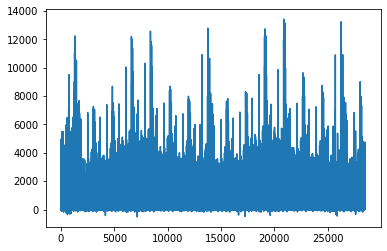

In [101]:
df_test['sales'].plot()

In [102]:
df_test[['id','sales']].set_index('id').to_csv('submission.csv')

In [97]:
df_clean

,store_nbr,family,onpromotion,isHoliday,holidayType,dcoilwtico,storeType,city,cluster,dayoftheWeek,month
0,1,0.0,0,0.0,4.0,93.14,3.0,18.0,13,3,1
1,1,1.0,0,0.0,4.0,93.14,3.0,18.0,13,3,1
2,1,2.0,0,0.0,4.0,93.14,3.0,18.0,13,3,1
3,1,3.0,0,0.0,4.0,93.14,3.0,18.0,13,3,1
4,1,4.0,0,0.0,4.0,93.14,3.0,18.0,13,3,1
...,...,...,...,...,...,...,...,...,...,...,...
2656957,9,28.0,0,1.0,3.0,47.57,1.0,18.0,6,2,8
2656958,9,29.0,1,1.0,3.0,47.57,1.0,18.0,6,2,8
2656959,9,30.0,148,1.0,3.0,47.57,1.0,18.0,6,2,8
2656960,9,31.0,8,1.0,3.0,47.57,1.0,18.0,6,2,8


In [96]:
df_test

,date,store_nbr,family,onpromotion,isHoliday,holidayType,dcoilwtico,storeType,city,cluster
0,2017-08-16,1,0.0,0,0.0,4.0,46.80,3.0,18.0,13
1,2017-08-16,1,1.0,0,0.0,4.0,46.80,3.0,18.0,13
2,2017-08-16,1,2.0,2,0.0,4.0,46.80,3.0,18.0,13
3,2017-08-16,1,3.0,20,0.0,4.0,46.80,3.0,18.0,13
4,2017-08-16,1,4.0,0,0.0,4.0,46.80,3.0,18.0,13
...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,28.0,1,0.0,4.0,47.26,1.0,18.0,6
28508,2017-08-31,9,29.0,0,0.0,4.0,47.26,1.0,18.0,6
28509,2017-08-31,9,30.0,1,0.0,4.0,47.26,1.0,18.0,6
28510,2017-08-31,9,31.0,9,0.0,4.0,47.26,1.0,18.0,6
